In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Inspecting the columns for station table
inspector = inspect(engine)
meas_col = inspector.get_columns('station')
for col in meas_col:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Inspecting the columns for measurement table
inspector = inspect(engine)
meas_col = inspector.get_columns('measurement')
for col in meas_col:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date_row = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date = recent_date_row[0]
recent_date

'2017-08-23'

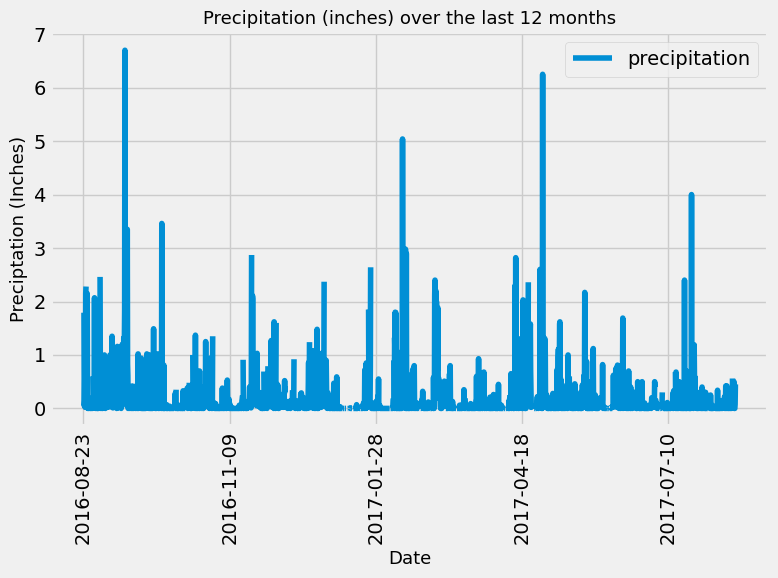

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23)- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
score = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_score_df = pd.DataFrame(score, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_score_df = prcp_score_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_score_df.plot(x='date', y='precipitation', kind='line', figsize=(8,6), rot=90)
plt.title('Precipitation (inches) over the last 12 months', fontsize=13)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Preciptation (Inches)', fontsize=13)
plt.tight_layout()
plt.show()

In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_score_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.id.distinct())).scalar()
station_count

9

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# which station id has the greatest number of observations?
most_active_id = most_active[0][0]
print(f'{most_active_id} has the greatest number of observation')

USC00519281 has the greatest number of observation


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(measurement.tobs),
                           func.max(measurement.tobs),
                           func.avg(measurement.tobs)).\
             filter(measurement.station == most_active_id).all()

print("Temperature statistics for station", most_active_id)
print("Lowest temperature:", temp_stats[0][0])
print("Highest temperature:", temp_stats[0][1])
print("Average temperature:", temp_stats[0][2])

Temperature statistics for station USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


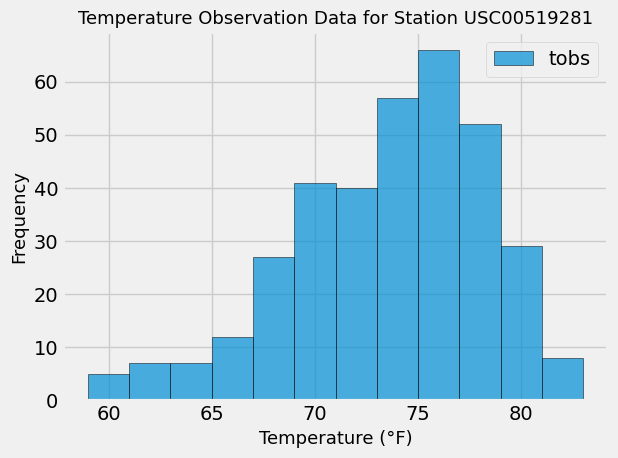

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query the temperature observation data for the most active station within the last 12 months
temp_data = session.query(measurement.date, measurement.tobs).\
            filter(measurement.station == most_active_id).\
            filter(measurement.date >= last_year).all()

# Convert the result to DataFrame
df_temp = pd.DataFrame(temp_data, columns=['Date', 'Temperature'])
# Plot the temperature observations as a histogram
plt.hist(df_temp['Temperature'], bins=12, alpha=0.7, edgecolor='black')

plt.title('Temperature Observation Data for Station USC00519281', fontsize=13)
plt.xlabel('Temperature (°F)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(['tobs'])
plt.grid(True)
plt.tight_layout()

plt.show()

# Close Session

In [ ]:
# Close Session
session.close()